# My first quantum circuit

In this notebook, you will see how to write a quantum circuit in Qiskit and execute it on a simulator and a real IBMQ device.

## Creating a quantum circuit

In [1]:
# Import libraries and objects
import numpy as np
from qiskit import QuantumCircuit

In [2]:
# Instantiate a quantum circuit object
circuit = QuantumCircuit(2)

# Add gates
circuit.h(0) # Hadamard on qubit 0
circuit.cx(0, 1) # CNOT between qubits 0 and 1
circuit.measure_all() # Measurement

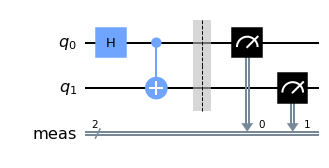

In [3]:
# Visualize the circuit
circuit.draw('mpl')

## Inspecting the final state

In [4]:
from qiskit.quantum_info import Operator

In [5]:
# Create a circuit object without the final measurement (Operator only accepts those)
circuit_without_mmt = circuit.remove_final_measurements(inplace=False)

# Circuit as a single unitary matrix
unitary = Operator(circuit_without_mmt)
print(unitary.data)

[[ 0.70710678+0.j  0.70710678+0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.70710678+0.j -0.70710678+0.j]
 [ 0.        +0.j  0.        +0.j  0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j  0.        +0.j  0.        +0.j]]


In [6]:
# Initial state is |0> = 1*|00> + 0*|01> + 0*|10> + 0*|11> -> [1, 0, 0, 0]
initial_state = np.array([1., 0., 0., 0.], dtype=np.complex128)

# Compute the final state through matrix multiplication
final_state = np.dot(unitary, initial_state)
print(final_state)

[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


The final state is $\frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)$, which is consistent with the quantum operation

$C_1^0[X]H_0|00\rangle = C_1^0[X] \left[|0\rangle \frac{1}{\sqrt{2}} (|0\rangle + |1\rangle)\right] = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle).$


## Executing the quantum circuit (simulator)

In Qiskit, entities that execute quantum circuits (simulators and real quantum devices) are referred to as "backends." Circuits must be "transpiled" first into a form executable by the individual backends. Minimally speaking, transpilation involves decomposition of multi-qubit gates into single- and double-qubit gates, insertion of SWAP gates to ensure that all two-qubit gates act on physically connected qubits, and trasnlation of arbitrary single-qubit gates into products of device-specific "basis gates." For a simulator backend, the last two steps are not necessary (the simulator corresponds to an ideal device with all-to-all qubit connectivity and an infinitely large set of basis gates), but we do go through the transpilation process nevertheless.

In [7]:
from qiskit import Aer, transpile
from qiskit.visualization import plot_histogram

In [8]:
# Get the simulator object
simulator = Aer.get_backend('qasm_simulator')

# Transpile the circuit into a form executable by the simulator
circuit_svsim = transpile(circuit, backend=simulator)

# Execute the circuit for 10k times
sim_job = simulator.run(circuit_svsim, shots=10000)

# Retrieve the result from the job object
sim_result = sim_job.result()

# Inspect the histogram data
print(sim_result.get_counts())

{'11': 4989, '00': 5011}


`backend.run()` returns a job object, `job.result()` returns a result object, and `result.get_counts()` returns a Python dict whose keys are the binary strings representing the results of the 0/1 measurement of the qubits, and the values are the number of circuit "shots" that yielded the respective measurement results. Note that for a local simulation like this, the job-result infrastructure is a bit of an overkill (the job executes and returns ~immediately). The steps are there so that the same program can be run on real devices by just swapping the backend object.

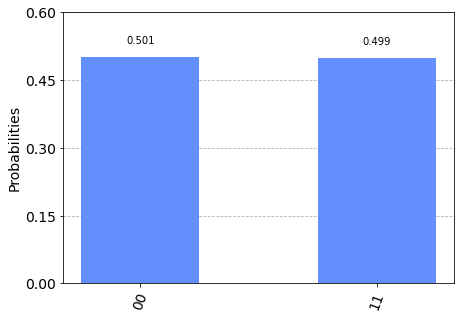

In [9]:
# Plot an actual histogram
plot_histogram(sim_result.get_counts())

## Executing the quantum circuit (IBMQ device)

In [10]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools import job_monitor

In [11]:
# Activate communication with the IBM Quantum server
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [12]:
# IBMQ provider manages access to various backends
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

# Filter function to choose an operational real-device backend with at least two qubits
def backend_filter(backend):
    config = backend.configuration()
    status = backend.status()
    return (not config.simulator) and (config.n_qubits >= 2) and status.operational

# List of backends satisfying the requirement
available_backends = provider.backends(filters=backend_filter)

# Choose the least busy backend among the available ones
backend = least_busy(available_backends)

print('Jobs will run on', backend.name())

Jobs will run on ibmq_quito


In [13]:
# Transpile the circuit for the backend
circuit_ibmq = transpile(circuit, backend=backend)

# Submit the circuit job to the backend
ibmq_job = backend.run(circuit_ibmq, shots=10000)

# This time, the job will not return immediately. Monitor its status
job_monitor(ibmq_job)

Job Status: job has successfully run


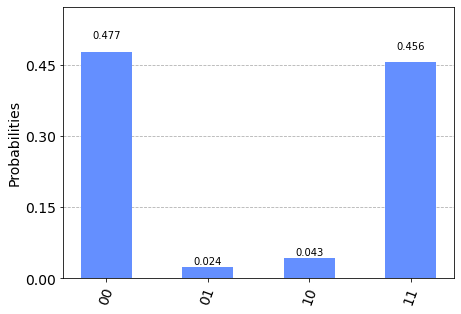

In [14]:
# Retrieve the result from the job object
ibmq_result = ibmq_job.result()

# Plot the histogram
plot_histogram(ibmq_result.get_counts())

Notice the existence of the "leakage" into 01 and 10 states; this is due to the hardware (gate and measurement) errors.

## Making the whole thing a little more interesting

A hallmark of the Bell state like $|00\rangle + |11\rangle$ is that it has no preferred single-qubit basis. Indeed, if you define

$|\theta\rangle := \cos\frac{\theta}{2} |0\rangle + \sin\frac{\theta}{2} |1\rangle$

and

$|\bar{\theta}\rangle := -\sin\frac{\theta}{2} |0\rangle + \cos\frac{\theta}{2} |1\rangle,$

then

$\frac{1}{\sqrt{2}} (|00\rangle + |11\rangle) = \frac{1}{\sqrt{2}} (|\theta\theta\rangle + |\bar{\theta}\bar{\theta}\rangle),$

implying that a measurement in the $\theta$-$\bar{\theta}$ basis will also yield a 0.5:0.5 result.

To test this, we need to define a circuit with projective measurements on non-Z axes. However, the measurement operator only works in the Z axis; this stems from the fact that the qubits are physically realized by two-level systems which actually have a preferred basis (energy eigenstates). We therefore instead apply qubit rotation gates so that the Z measurements become equivalent to measurements in the $\theta$/$\bar{\theta}$ measurements.

In [15]:
from qiskit.circuit import Parameter

/usr/local/lib/python3.8/dist-packages/sympy/core/expr.py:2451: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


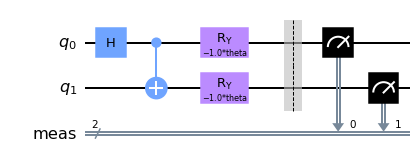

In [16]:
# Copy the original circuit without the measurement
theta_circuit = circuit_without_mmt.copy()

# Placeholder angle theta whose value can be set later
theta = Parameter('theta')

# Apply Ry gates to "change the measurement axes"
theta_circuit.ry(-theta, [0, 1]) # Gates can be applied to multiple qubits in one function call

# Add the measurement operators and draw
theta_circuit.measure_all()
theta_circuit.draw('mpl')

In [17]:
# Define ten circuits with random theta values
circuits = []
for _ in range(10):
    random_angle = np.random.rand() * 2. * np.pi
    circuits.append(theta_circuit.bind_parameters({theta: random_angle}))

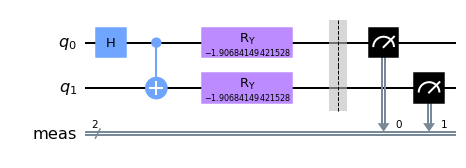

In [18]:
circuits[0].draw('mpl')

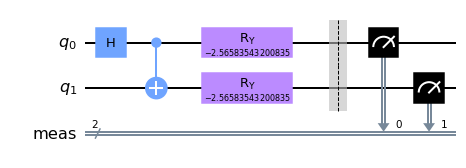

In [19]:
circuits[1].draw('mpl')

In [20]:
# Transpile the circuits for the backend (tranpile() also accepts a list of circuits)
circuits_ibmq = transpile(circuits, backend=backend)

# Submit the job to execute 10k shots x 10 circuits
ibmq_job_theta = backend.run(circuits_ibmq, shots=10000)

# Monitor the job status
job_monitor(ibmq_job_theta)

Job Status: job has successfully run


In [24]:
# Retrieve the result from the job object
ibmq_result = ibmq_job_theta.result()

This time, the result object contains the result for 10 circuits. We therefore need to give the circuit number to `get_counts()` to specify whose result we want.

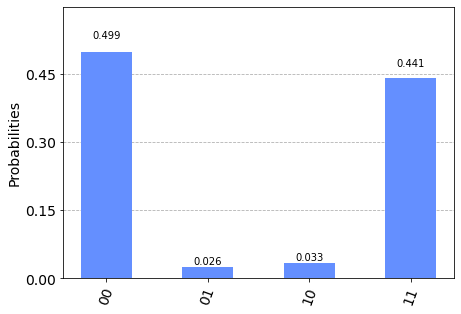

In [25]:
# Plot the histogram of the 0th circuit
plot_histogram(ibmq_result.get_counts(0))

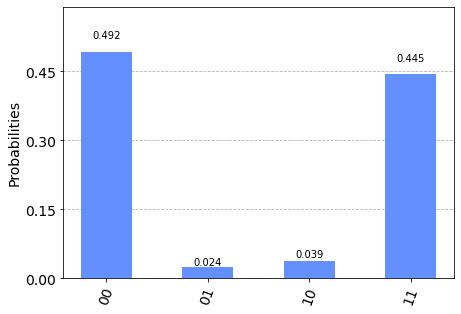

In [26]:
# Plot the histogram of the 8th circuit
plot_histogram(ibmq_result.get_counts(8))

You can try `plot_histogram` for all 10 circuits. The result should always be ~0.5:0.5 on 00 and 11 and some residual error-induced counts in 01 and 10. You can also try changing the measurement axes between the two qubits and perform a CHSH-type experiment with this circuit.